In [454]:
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn import linear_model, preprocessing
from sklearn.metrics import accuracy_score as auc
from sklearn import cross_validation as cv

from matplotlib import pyplot as plt

# Load training times
train_epl00 = pd.read_csv('./data/EPL00_01.csv', encoding="ISO-8859-1")
train_epl01 = pd.read_csv('./data/EPL01_02.csv', encoding="ISO-8859-1")
train_epl02 = pd.read_csv('./data/EPL02_03.csv', encoding="ISO-8859-1")

# Load testing files
test_epl03 = pd.read_csv('./data/EPL03_04.csv', encoding="ISO-8859-1")
test_epl04 = pd.read_csv('./data/EPL04_05.csv', encoding="ISO-8859-1")

# Concat all training and test files into one structure
df_train = pd.concat((train_epl00, train_epl01, train_epl02), axis=0, ignore_index=True)
df_test = pd.concat((test_epl03, test_epl04), axis=0, ignore_index=True)

In [455]:
# Number of records in training set
num_train = df_train.shape[0]
print(str(num_train) + " records read from multiple training files")

# Number of records in test set
num_test = df_test.shape[0]
print(str(num_test) + " records read from multiple test files")

1140 records read from multiple training files
760 records read from multiple test files


In [456]:
# Calculate points from FTR (Full time Result)
def points(set_type):
    ''' Follows the league distribution of points in response to a result '''
    set_type['Result'] = np.NaN
    
    for index, item in set_type['FTR'].iteritems():
        if (item == 'H'):
            set_type.set_value(index, 'Result', 3.0)
        elif (item == 'A'):
            set_type.set_value(index, 'Result', 0.0)
        else:
            set_type.set_value(index, 'Result', 1.0)

# Calculate goal difference
def diff(set_type, col1, col2, new_col):
    ''' Difference of two columns col1 - col2 = new_col '''
    set_type[new_col] = np.NaN # Set all values to zero
    home_g = set_type[col1] # Placeholder values
    away_g = set_type[col2]
    set_type[new_col] = home_g - away_g # Calculate the difference in fulltime scores

# Calculate points - Result
points(df_train)
points(df_test)

# Calculate full time goal difference
diff(df_train, 'FTHG', 'FTAG', 'FTGD')
diff(df_test, 'FTHG', 'FTAG', 'FTGD')

# Calculate half time goal difference
diff(df_train, 'HTHG', 'HTAG', 'HTGD')
diff(df_test, 'HTHG', 'HTAG', 'HTGD')

#: Calculate shot taken on target difference - SOTD 
diff(df_train, 'HST', 'AST', 'SOTD')
diff(df_test, 'HST', 'AST', 'SOTD')

#: Calculate shots taken overall difference - STD 
diff(df_train, 'HS', 'AS', 'STD')
diff(df_test, 'HS', 'AS', 'STD')
    

#: Isolate Arsenal FC to review season performance
arsenal_str = 'Arsenal'      
arsenal_train = df_train.loc[(df_train['HomeTeam'] == arsenal_str) | (df_train['AwayTeam'] == arsenal_str)]
arsenal_test = df_test.loc[(df_test['HomeTeam'] == arsenal_str) | (df_test['AwayTeam'] == arsenal_str)]

In [457]:
#: These columns were dropped so that we could extract values!
drop_col = ['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'HTR', 'Result', 'FTHG', 'FTAG', 'HTHG', 'HTAG', \
            'HR', 'AR', 'HY', 'AY', 'HST', 'AST', 'HS', 'AS']
ars_train_del = arsenal_train.drop(drop_col, axis = 1)
ars_test_del = arsenal_test.drop(drop_col, axis = 1)

In [458]:
#: Normalize values?

#: Transform to numpy array - the X in linear reg
ars_trval = ars_train_del.values.astype(float)
ars_teval = ars_test_del.values.astype(float)

#: Activate sklearn - normalize object 
min_max_scaler = preprocessing.MinMaxScaler()
ars_train_val = min_max_scaler.fit_transform(ars_trval)
ars_test_val = min_max_scaler.fit_transform(ars_teval)

print('Train X:' , ars_train_val.shape)
print('Test X:', ars_test_val.shape)

# vector y in linear regr
target_train = np.array(arsenal_train['Result'])
target_test = np.array(arsenal_test['Result'])


print('Train y:' , target_train.shape)
print('Test y:', target_test.shape)

Train X: (114, 4)
Test X: (76, 4)
Train y: (114,)
Test y: (76,)


In [465]:
#: Retrieve the results for cross-validation

#: Collect whole data
data = ars_train_del.as_matrix().astype(np.float)

#: Target data
target = arsenal_train.Result.as_matrix().astype(np.int)

def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cv.StratifiedKFold(y, n_folds=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    for ii, jj in stratified_k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred
        

print('Logistic Regression CV: {:.2f}'.format(auc(target, stratified_cv(data, target, linear_model.LogisticRegression))))    

Logistic Regression CV: 0.90


Accuracy score: 0.75


C:\Users\oakejp12\AppData\Local\Continuum\Miniconda3\envs\csc322\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


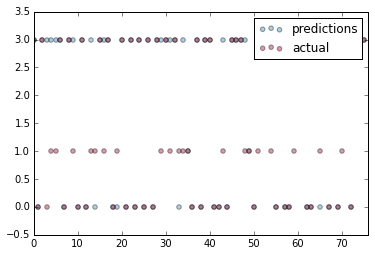

In [488]:
# Preform Logistic Regression - multinomial
logr = linear_model.LogisticRegression()

# Train the logistic regression model & predict
logr.fit(ars_train_val, target_train)
yhat = logr.predict(ars_test_val)

print('Accuracy score:', auc(target_test, yhat))


plt.scatter(range(yhat.shape[0]), yhat, label='predictions', c='#348ABD', alpha=0.4)
plt.scatter(range(target_test.shape[0]), target_test, label='actual', c='#A60628', alpha=0.4)
plt.xlim([0, yhat.shape[0]])
plt.legend();

C:\Users\oakejp12\AppData\Local\Continuum\Miniconda3\envs\csc322\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


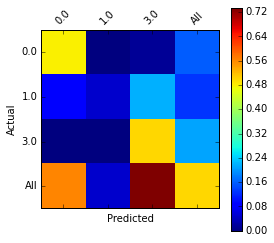

In [461]:
# Confusion Matrix
y_actual = pd.Series(target_test, name='Actual')
y_pred = pd.Series(yhat, name='Predicted')

# Turn into a pandas data frame
df_confusion = pd.crosstab(y_actual, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

def plot_cm(matrix, title='Confusion Matrix'):
    plt.matshow(matrix)
    # plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(matrix.columns))
    plt.xticks(tick_marks, matrix.columns, rotation=45)
    plt.yticks(tick_marks, matrix.index)
    plt.ylabel(matrix.index.name)
    plt.xlabel(matrix.columns.name)
    
# Normalize confusion matrix
df_conf_norm = df_confusion / df_confusion.sum(axis=1)

plot_cm(df_conf_norm)    